In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import WMAP9

In [2]:
def schechter(logphi, M, Mo, a):

    Mo = np.asarray([Mo]*len(M))

    return np.log(10)*(10**logphi)*10**((M-Mo)*(a+1))*np.exp(-10**(M-Mo))

def double_schechter(M, logphi1, logphi2, Mo, a1, a2):

    return schechter(logphi1, M, Mo, a1) + schechter(logphi2, M, Mo, a2)

In [3]:
def parameter_at_z0(y,z,z1=0.2,z2=1.6,z3=3.0):

    y1,y2,y3 = y
    a = ((y3-y1) + ((y2-y1) / (z2-z1)) * (z1-z3)) / ((z3**2-z1**2 + ((z2**2-z1**2) / (z2-z1)) * (z1-z3)))
    b = ((y2-y1) - a * (z2**2-z1**2)) / (z2-z1)
    c = y1-a*z1**2-b*z1

    return a*(z**2)+b*z+c

In [4]:
def mass_function(logm, z, 
                  y_logphi1=[-2.44, -3.08, -4.14], 
                  y_logphi2 = [-2.89, -3.29, -3.51], 
                  y_M0 = [10.79,10.88,10.84], 
                  alpha1 = [-0.28], 
                  alpha2 = [-1.48]):

    phi1 = parameter_at_z0(y_logphi1, z)
    phi2 = parameter_at_z0(y_logphi2, z)
    logM0 = parameter_at_z0(y_M0, z)

    return np.log10(double_schechter(logm, phi1, phi2, logM0, alpha1[0], alpha2[0]))



In [13]:
def galaxy_density(logm, z1, z2):
    
    Phi_tot = 0
    zs = np.linspace(z1, z2, 100)
    for z in zs:
        Phi_tot+=((10**mass_function(logm, z)))
    
    return Phi_tot

In [20]:
def background_redshift_distribution(logm, zs):

    Nz = []
    i = 1
    while(i < len(zs)):

        Nz.append(galaxy_density(logm, zs[i-1], zs[i])*(WMAP9.comoving_volume(zs[i]).value-WMAP9.comoving_volume(zs[i-1]).value))
        i+=1

    return np.hstack(Nz)

Text(0, 0.5, 'log10(phi)[Mpc-3dex-1]')

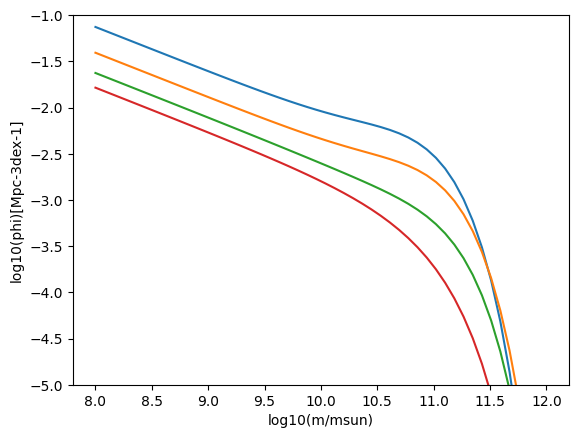

In [7]:
mass = np.log10(np.logspace(8,12))
plt.plot(mass, mass_function(mass, 0))
plt.plot(mass, mass_function(mass, 1))
plt.plot(mass, mass_function(mass, 2))
plt.plot(mass, mass_function(mass, 3))
plt.ylim(-5, -1)
plt.xlabel('log10(m/msun)')
plt.ylabel('log10(phi)[Mpc-3dex-1]')

(0.0, 3.0)

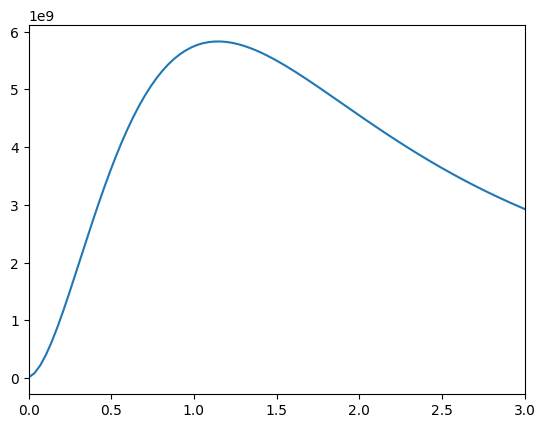

In [25]:
zs = np.linspace(0, 7, 200)
mass = np.array([10])
Nz = background_redshift_distribution(mass, zs)
plt.plot(zs[:199], Nz)
plt.xlim(0,3)